In [ ]:
import warnings
from utils.plotting_helpers import plot_weights
from environements.portfolio_optimization_env_flat import PortfolioOptimizationEnvFlat
import matplotlib as mpl
from utils.portfolio_trainer import PortfolioOptimization
from pandas import read_csv
from utils.yahoo_downloader import YahooDownloader
from utils.feature_engineer import FeatureEngineer
from utils.helpers import data_split
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scienceplots
from utils.plotting_helpers import plot_mvo_weights
import utils.mean_variance_optimization as mvo
df_dow = read_csv('./data/dow.csv')
from utils.mean_variance_optimization import mvo_data

# mpl.rcParams['figure.dpi'] = 300
import math
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./dataset/dax_complete.csv')
df_sp500 = read_csv('./data/sp500.csv')
warnings.filterwarnings("ignore")


def linear_schedule(initial_value):
    def scheduler(progress_remaining):
        return initial_value * progress_remaining
    return scheduler

In [52]:
df = df_dow.copy()

df = df_dow[df_dow.tic.isin([ 'AXP', 'DIS', 'GS', 'MMM', 'UNH','MCD','CAT','CRM','V','AMGN','TRV','MSFT'])]
# df = df[df.tic.isin(['ADS.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 'BMW.DE', 'CON.DE', 'DBK.DE', 'DTE.DE', 'EOAN.DE', 'FME.DE', 'VOW3.DE'])]
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-01-01'
INDICATORS = [
    "macd",
    "rsi_30",
]

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list=INDICATORS,
                     use_turbulence=False,
                     user_defined_feature=True)

processed_prcies = fe.preprocess_data(df.query('date>"2000-01-01"'))
cleaned_data = processed_prcies.copy()
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf, 0)
stock_dimension = len(cleaned_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 10


In [53]:
# Compute exponentially weighted std of log returns
for window in [21, 42, 63,252]:
    cleaned_data[f'std_return_{window}'] = cleaned_data.groupby('tic')['log_return'] \
        .transform(lambda x: x.ewm(span=window, min_periods=window,adjust=False).std() )
# Compute exponentially weighted std of closing prices for MACD normalization
cleaned_data['ewma_std_price_63'] = cleaned_data.groupby('tic')['close'] \
    .transform(lambda x: x.ewm(span=63, min_periods=60,adjust=False).std())

# Normalize MACD by price volatility
cleaned_data['macd_normal'] = cleaned_data['macd'] / cleaned_data['ewma_std_price_63']

# Rolling cumulative log returns over different periods
for window in [21, 42, 63,252]:
    cleaned_data[f'return_sum_{window}'] = cleaned_data.groupby('tic')['log_return'] \
        .transform(lambda x: x.ewm(span=window, min_periods=window,adjust=False).mean())

# Normalize rolling log returns by their respective volatilities
for window in [21, 42, 63,252]:
    cleaned_data[f'r_{window}'] = cleaned_data[f'return_sum_{window}'] / cleaned_data[f'std_return_{window}']
cleaned_data['rsi_30'] = cleaned_data['rsi_30']/100

In [54]:
cleaned_data

,Unnamed: 0,date,open,high,low,close,volume,tic,day,macd,...,ewma_std_price_63,macd_normal,return_sum_21,return_sum_42,return_sum_63,return_sum_252,r_21,r_42,r_63,r_252
0,1,2000-01-03,70.000000,70.000000,62.875000,44.260464,22914900,AMGN,0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6288,2,2000-01-03,47.995617,47.995617,45.515598,32.595165,6471267,AXP,0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12576,4,2000-01-03,23.843750,24.500000,23.843750,12.717304,5055000,CAT,0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18864,7,2000-01-03,28.855125,29.533344,28.361876,22.833183,8402230,DIS,0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25152,8,2000-01-03,94.187500,94.375000,87.750000,62.611706,1822600,GS,0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37727,180611,2024-12-30,291.470001,291.470001,289.000000,289.600006,1936700,MCD,0,-0.847394,...,9.755785,-0.086861,-0.001512,-0.000789,-0.000391,0.000257,-0.169406,-0.080463,-0.037766,0.023400
44015,180612,2024-12-30,129.119995,129.919998,127.919998,129.130005,2154000,MMM,0,-0.291080,...,6.349534,-0.045843,-0.000494,-0.000305,-0.000003,0.001209,-0.043720,-0.023495,-0.000189,0.064740
50303,180614,2024-12-30,426.059998,427.549988,421.899994,424.829987,13158700,MSFT,0,1.384540,...,13.229015,0.104659,-0.002522,-0.000793,-0.000333,0.000351,-0.194242,-0.060048,-0.025236,0.026431
56591,180617,2024-12-30,239.880005,241.169998,237.610001,239.869995,734300,TRV,0,-3.734955,...,13.535947,-0.275929,-0.002557,-0.001531,-0.000742,0.000668,-0.207304,-0.109886,-0.050223,0.044617


<Axes: xlabel='date'>

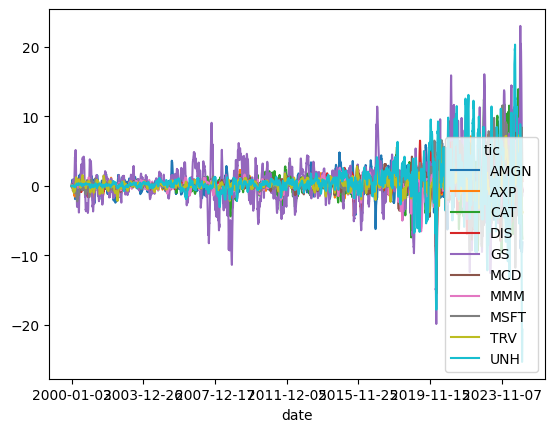

In [60]:
%matplotlib inline

pv = cleaned_data.pivot_table(index='date',columns='tic',values='macd')
pv.plot()

In [34]:
covs = mvo.mvo_data(cleaned_data,risk_model='sample_cov')

In [36]:
with open('./data/dax_normal_processed.pkl', 'wb') as file: 
    pickle.dump(cleaned_data, file) 

In [61]:
with open('./data/dow_processed.pkl', 'wb') as file: 
    pickle.dump(covs, file) 

In [64]:
with open('./data/dow_processed.pkl', 'rb') as file: 
    cleaned_data = pickle.load(file)

In [48]:
with open('./data/dow_normal_processed.pkl', 'rb') as file:
     cleaned_data= pickle.load(file)

In [49]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2020-12-30'

VALIDATION_START_DATE = '2021-01-01'
VALIDATION_END_DATE = '2021-12-30'

TEST_START_DATE = '2022-01-01'
TEST_END_DATE = '2024-12-30'
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(
    cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())


In [50]:
cleaned_data

,Unnamed: 0,date,open,high,low,close,volume,tic,day,macd,...,std_return_42,std_return_63,ewma_std_price_63,macd_normal,return_sum_21,return_sum_42,return_sum_63,r_21,r_42,r_63
0,1,2000-01-03,70.000000,70.000000,62.875000,44.260464,22914900,AMGN,0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6288,2,2000-01-03,47.995617,47.995617,45.515598,32.595165,6471267,AXP,0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12576,4,2000-01-03,23.843750,24.500000,23.843750,12.717304,5055000,CAT,0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18864,7,2000-01-03,28.855125,29.533344,28.361876,22.833183,8402230,DIS,0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25152,8,2000-01-03,94.187500,94.375000,87.750000,62.611706,1822600,GS,0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37727,180611,2024-12-30,291.470001,291.470001,289.000000,289.600006,1936700,MCD,0,-0.847394,...,0.009802,0.010348,9.755785,-0.086861,-0.001512,-0.000789,-0.000391,-0.169406,-0.080463,-0.037766
44015,180612,2024-12-30,129.119995,129.919998,127.919998,129.130005,2154000,MMM,0,-0.291080,...,0.012978,0.014517,6.349534,-0.045843,-0.000494,-0.000305,-0.000003,-0.043720,-0.023495,-0.000189
50303,180614,2024-12-30,426.059998,427.549988,421.899994,424.829987,13158700,MSFT,0,1.384540,...,0.013214,0.013213,13.229015,0.104659,-0.002522,-0.000793,-0.000333,-0.194242,-0.060048,-0.025236
56591,180617,2024-12-30,239.880005,241.169998,237.610001,239.869995,734300,TRV,0,-3.734955,...,0.013933,0.014783,13.535947,-0.275929,-0.002557,-0.001531,-0.000742,-0.207304,-0.109886,-0.050223


In [16]:
pv_simple_return = train_data.pivot_table(index='date',values='return',columns='tic')
pv_simple_log_return = train_data.pivot_table(index='date',values='log_return',columns='tic')
pv_simple_rsi = train_data.pivot_table(index='date',values='rsi_30',columns='tic')
pv_simple_macd_normal= train_data.pivot_table(index='date',values='macd_normal',columns='tic')
pv_simple_std= train_data.pivot_table(index='date',values='ewma_std_price_63',columns='tic')
pv_m_21= train_data.pivot_table(index='date',values='return_sum_21',columns='tic')



In [ ]:
%matplotlib inline

pv_simple_return.plot()
pv_simple_log_return.plot()
pv_simple_rsi.plot()
pv_simple_macd_normal.plot()



# Proximal Policy Optimization

In [42]:
%matplotlib inline

import torch
from torch import nn

from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
activ_func = nn.SiLU
use_sharpe_reward = False
optimizer = PortfolioOptimization(
    transaction_fee=0, comission_fee_model=None,
    tag="flat_state", sharp_reward=use_sharpe_reward, last_weight=False, remove_close=True,flatten_state=False,
    add_cash=False, env=PortfolioOptimizationEnv
)
# optimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return", "r_21", "r_42", "r_63",
#                                 "macd", "rsi_30"
#                                 ],
#                         model_name="td3",
#                         args={'gamma': 0.90, 'learning_rate': 1e-4,
#                             "buffer_size": 300_000, "batch_size": 124,
#                             "action_noise": "normal"},
#                         window_size=21,
#                         policy_kwargs=dict(
#                             activation_fn=activ_func,
#                         ),
#                         iterations=1000_000)

test_env = optimizer.create_environment(test_data,
                          features=["close", "log_return", "r_21", "r_42", "r_63","r_252",
                                    "macd", "rsi_30",
                                    ],
                                        window=21)
ppo_test_result = optimizer.load_from_file(
    'RecurrentPPO',test_env, 
    cwd="data/RecurrentPPO_close_log_return_r_21_r_42_r_63_r_252_macd_rsi_30_window_size_21_0.001_recurrent_ppo_dax_dataset_leaky_relu/RecurrentPPO_100000_steps"
    ,deterministic=True)

KeyError: 'Column not found: r_252'

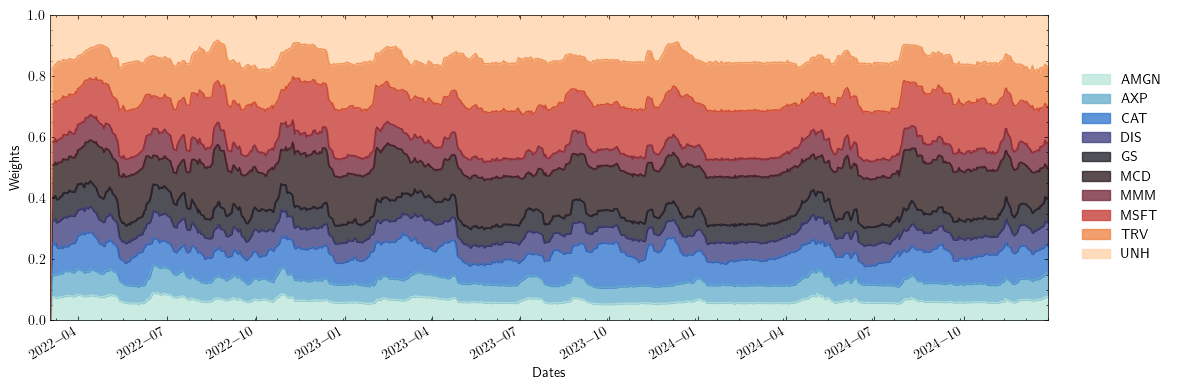

In [148]:
from utils.plotting_helpers import plot_weights
plot_weights(ppo_test_result[0].weights, ppo_test_result[0].date, ppo_test_result[1],add_cash=False)

# TD3

In [5]:
from models import MODELS


def load_from_file( model_name, environment, cwd, deterministic=True):
    if model_name not in MODELS:
        raise ValueError(
            f"Model '{model_name}' not found in MODELS."
        )  # this is more informative than NotImplementedError("NotImplementedError")
    try:
        # load agent
        model = MODELS[model_name].load(cwd)
        print("Successfully load model", cwd)
    except BaseException as error:
        raise ValueError(
            f"Failed to load agent. Error: {str(error)}") from error

    # test on the testing env
    state = environment.reset()[0]
    done = False
    tiks = environment._tic_list.tolist()
    while not done:
        state = state.reshape(1,-1)
        action = model.predict(state, deterministic=deterministic)[0]
        date_list = environment._date_memory
        portfolio_return = environment._portfolio_return_memory
        result_df = pd.DataFrame(
            {"date": date_list, "daily_return": portfolio_return,
                'account':  environment._asset_memory["final"], 'weights': environment._final_weights}
        )
        state, reward, done, _, _ = environment.step(action)
    return result_df, tiks

In [150]:
%matplotlib inline

import torch
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = PortfolioOptimization(
    transaction_fee=0, comission_fee_model=None,
    tag="flat_state", sharp_reward=False, last_weight=False, remove_close=True,flatten_state=True,
    add_cash=False, env=PortfolioOptimizationEnv
)
# optimizer.train_model(train_data,
#                       validation_data,
#                       features=["close", "log_return", "r_21", "r_42", "r_63",
#                                 "macd", "rsi_30","corr_list"
#                                 ],
#                       model_name="ppo",
#                       args={"n_steps":  1024, "batch_size": 64, 'learning_rate': 1e-4,
#                             'gamma': 0.85, 'gae_lambda': 0.85, 'ent_coef': 0.05},
#                       window_size=5,
#                       iterations=1000_000)

test_env = optimizer.create_environment(test_data,features=[
                                "close", "log_return", "r_21", "r_42", "r_63",
                                "macd", "rsi_30",'corr_list'
                                  ],window=42)
td3_test_result = load_from_file(
    'td3',test_env, 
    cwd="data/td3_close_log_return_r_21_r_42_r_63_macd_rsi_30_corr_list_window_size_42_0.001_td3_leaky_relu/td3_310000_steps"
    ,deterministic=True)

Successfully load model data/td3_close_log_return_r_21_r_42_r_63_macd_rsi_30_corr_list_window_size_42_0.001_td3_leaky_relu/td3_310000_steps
Initial portfolio value:250000
Final portfolio value: 351331.9375
Final accumulative portfolio value: 1.4053277969360352
Maximum DrawDown: -0.18040545767680094
Sharpe ratio: 0.8222973573974212


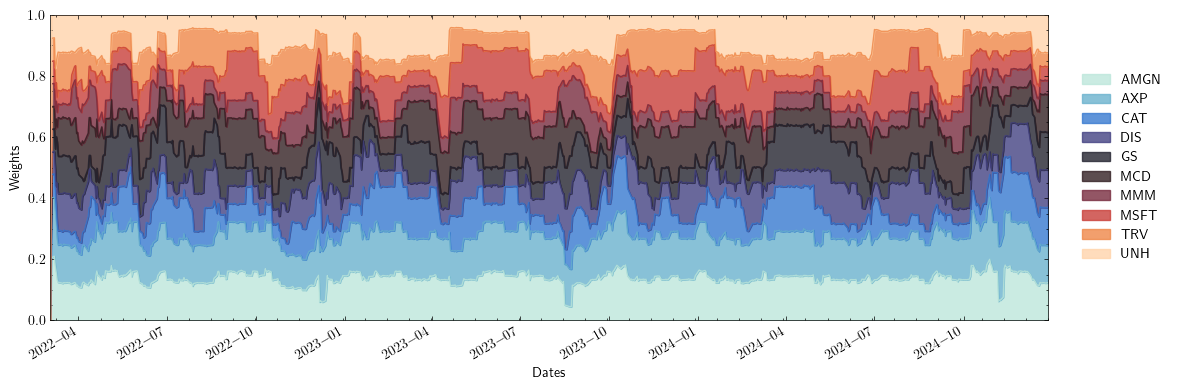

In [151]:
from utils.plotting_helpers import plot_weights
plot_weights(td3_test_result[0].weights, td3_test_result[0].date, td3_test_result[1],add_cash=False,name='td3')

# Mean Variance Optimization

In [6]:
covariances = mvo.mvo_data(cleaned_data,'mean_historical_return')

In [159]:
TEST_START_DATE

'2022-01-01'

In [160]:
test_covariances = data_split(covariances,TEST_START_DATE,TEST_END_DATE)
min_variacen_portfolio = mvo.mean_variance_optimization(test_covariances,commission_fee=0,window=42)
%matplotlib inline
plot_weights(min_variacen_portfolio[0].weights, min_variacen_portfolio[0].date, min_variacen_portfolio[1],add_cash=False,name='mvo_dow')

Initial portfolio value:1000000
Final portfolio value: 1270391.5
Final accumulative portfolio value: 1.2703914642333984
Maximum DrawDown: -0.1363493243974857
Sharpe ratio: 0.673829006472675


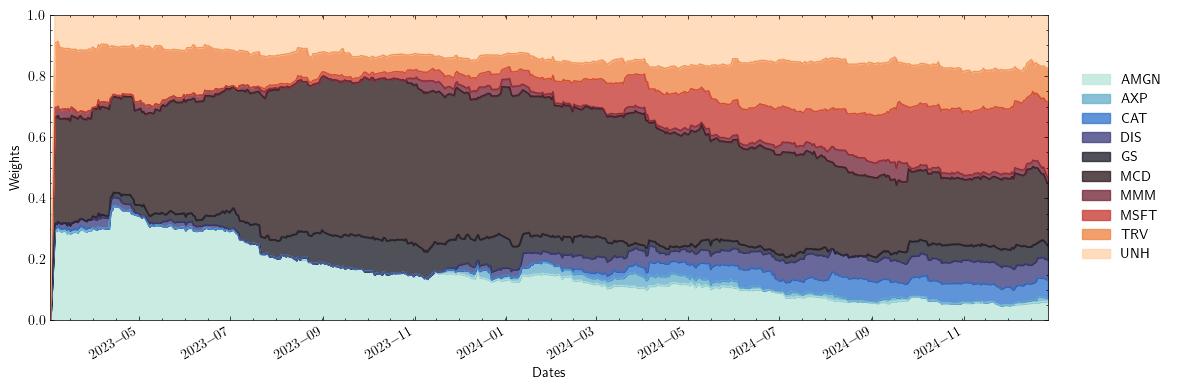

In [47]:
%matplotlib inline
plot_weights(min_variacen_portfolio[0].weights, min_variacen_portfolio[0].date, min_variacen_portfolio[1],add_cash=False,name='mvo_dow')

Initial portfolio value:1000000
Final portfolio value: 1165809.25
Final accumulative portfolio value: 1.1658092737197876
Maximum DrawDown: -0.3573458259158625
Sharpe ratio: 0.3809366627142422


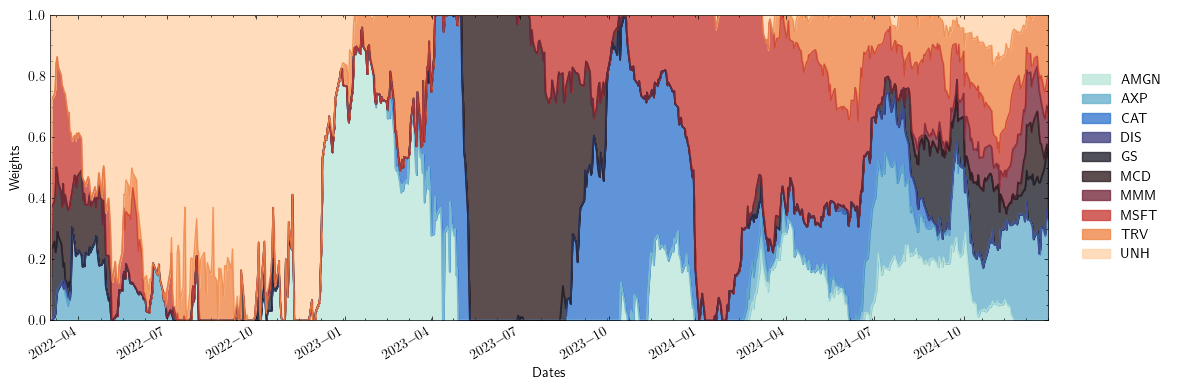

In [161]:
result_sharpe = mvo.mean_variance_optimization(test_covariances,commission_fee=0,objective='sharpe',window=42,risk_free_rate=0.04)
%matplotlib inline
plot_weights(result_sharpe[0].weights, result_sharpe[0].date, result_sharpe[1],add_cash=False,name='mvo_sharpe')

Initial portfolio value:1000000
Final portfolio value: 1113015.875
Final accumulative portfolio value: 1.11301589012146
Maximum DrawDown: -0.23064975
Sharpe ratio: 0.44302152632623965


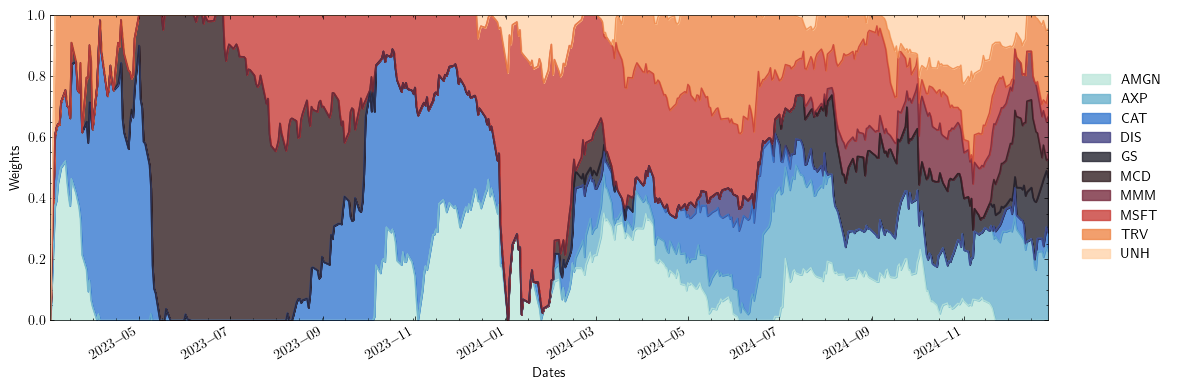

In [34]:
result_sharpe = mvo.mean_variance_optimization(test_covariances,commission_fee=0,objective='sharpe',window=42)
%matplotlib inline
plot_weights(result_sharpe[0].weights, result_sharpe[0].date, result_sharpe[1],add_cash=False,name='mvo_sharpe')

# Buy and Hold

In [99]:
from environements.portfolio_optimization_env import PortfolioOptimizationEnv


stock_dimension = len(test_data.tic.unique())
environment_train_buy_and_hold_sp500 = PortfolioOptimizationEnv(
    test_data,
    initial_amount=1000000,
    comission_fee_pct=0,
    time_window=42,
    features = ["close","return"],
    normalize_df=None,
    add_cash=False
)
terminated = False

environment_train_buy_and_hold_sp500.reset()

while not terminated:
    action = [1/stock_dimension] * stock_dimension
    _, _, terminated,_, _ = environment_train_buy_and_hold_sp500.step(
        np.array(action, dtype=np.float32))

Initial portfolio value:1000000
Final portfolio value: 1452473.0
Final accumulative portfolio value: 1.4524730443954468
Maximum DrawDown: -0.1789132719126646
Sharpe ratio: 0.905380885750904


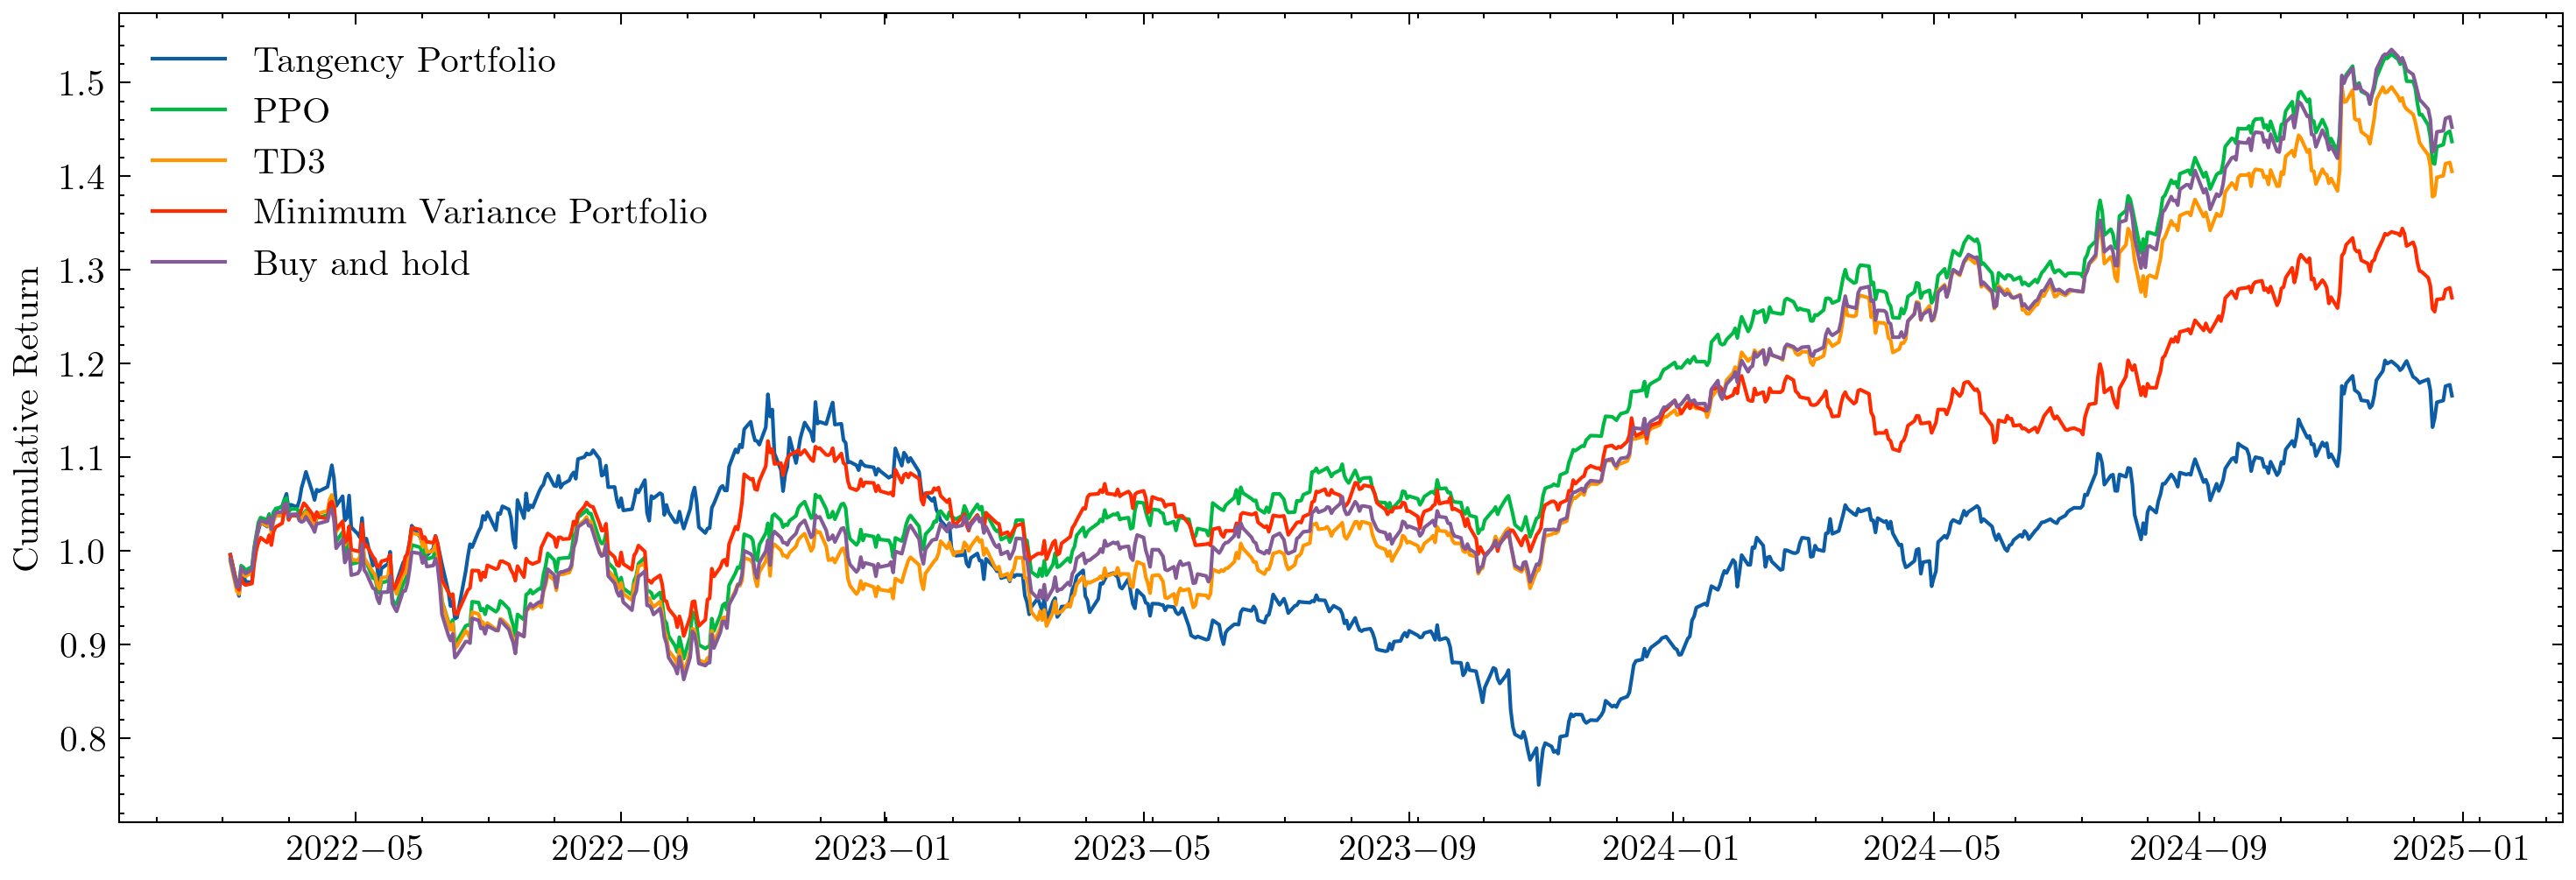

In [162]:
import matplotlib.pyplot as plt
import scienceplots
plt.rcdefaults()
%matplotlib inline
with plt.style.context('science', 'ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    plt.plot(result_sharpe[0].get('date'),(result_sharpe[0]['account'].pct_change() + 1).cumprod(),label='Tangency Portfolio')
    plt.plot(ppo_test_result[0].get('date'),(ppo_test_result[0]['account'].pct_change() +1).cumprod(),label='PPO')
    plt.plot(td3_test_result[0].get('date'),(td3_test_result[0]['account'].pct_change() +1).cumprod(),label='TD3')
    plt.plot(min_variacen_portfolio[0].get('date'),(min_variacen_portfolio[0]['account'].pct_change() + 1).cumprod(),label='Minimum Variance Portfolio')
    plt.plot(environment_train_buy_and_hold_sp500._date_memory,(pd.Series(environment_train_buy_and_hold_sp500._asset_memory["final"]).pct_change() + 1).cumprod(),label='Buy and hold')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.savefig('dow_comparison.png', dpi=500)
    plt.show()

In [18]:
import quantstats as qs

In [19]:
ppo_returns = ppo_test_result[0][['date','account']]

ppo_stats={}
ppo_returns.set_index('date',inplace=True)
ppo_stats['name']  = 'Proximal Policy Optimization'
ppo_stats['sharpe_ratio'] = qs.stats.sharpe(ppo_returns)['account']
ppo_stats['max_drow_down'] = qs.stats.max_drawdown(ppo_returns)['account']
ppo_stats['var'] = qs.stats.var(ppo_returns)[0].item()
ppo_stats['return'] = qs.stats.comp(ppo_returns['account'].pct_change())
ppo_stats

{'name': 'Proximal Policy Optimization',
 'sharpe_ratio': np.float64(1.5185592892133368),
 'max_drow_down': np.float64(-0.08593042387717309),
 'var': -0.0128718753812446,
 'return': np.float64(0.4175447499999967)}

In [20]:
td3_returns = td3_test_result[0][['date','account']]

td3_stats={}
td3_returns.set_index('date',inplace=True)
td3_stats['name']  = 'TD3'
td3_stats['sharpe_ratio'] = qs.stats.sharpe(td3_returns)['account']
td3_stats['max_drow_down'] = qs.stats.max_drawdown(td3_returns)['account']
td3_stats['var'] = qs.stats.var(td3_returns)[0].item()
td3_stats['return'] = qs.stats.comp(td3_returns['account'].pct_change())
td3_stats

{'name': 'TD3',
 'sharpe_ratio': np.float64(1.2460589379169966),
 'max_drow_down': np.float64(-0.08202283627157536),
 'var': -0.012741925393063605,
 'return': np.float64(0.33720850000000113)}

In [21]:
mvo_min_returns = min_variacen_portfolio[0][['date','account']]
mvo_min_returns.set_index('date',inplace=True)

mvo_min_stats={}
mvo_min_stats['name']  = 'Min variance portfolio'
mvo_min_stats['sharpe_ratio'] = qs.stats.sharpe(mvo_min_returns)['account']
mvo_min_stats['max_drow_down']  = qs.stats.max_drawdown(mvo_min_returns)['account']
mvo_min_stats['var']  = qs.stats.var(mvo_min_returns)[0].item()
mvo_min_stats['return'] = qs.stats.comp(mvo_min_returns['account'].pct_change())
mvo_min_stats

{'name': 'Min variance portfolio',
 'sharpe_ratio': np.float64(1.0339419311856881),
 'max_drow_down': np.float64(-0.07211276821112178),
 'var': -0.011924268617278343,
 'return': np.float64(0.23685149999999822)}

In [22]:

mvo_sharpe_returns = result_sharpe[0][['date','account']]
mvo_sharpe_returns.set_index('date',inplace=True)
mvo_sharpe_stats={}
mvo_sharpe_stats['name']  = 'Tangency Portfolio'
mvo_sharpe_stats['sharpe_ratio'] = qs.stats.sharpe(mvo_sharpe_returns)['account']
mvo_sharpe_stats['max_drow_down']  = qs.stats.max_drawdown(mvo_sharpe_returns)['account']
mvo_sharpe_stats['var']  = qs.stats.var(mvo_sharpe_returns)[0].item()
mvo_sharpe_stats['return'] = qs.stats.comp(mvo_sharpe_returns['account'].pct_change())
mvo_sharpe_stats

{'name': 'Tangency Portfolio',
 'sharpe_ratio': np.float64(0.6639631177056547),
 'max_drow_down': np.float64(-0.2340280484750007),
 'var': -0.017158864857159548,
 'return': np.float64(0.19624812499999678)}

In [23]:
bh_df = pd.DataFrame()
bh_df['asset']=environment_train_buy_and_hold_sp500._portfolio_return_memory
bh_df['date']=environment_train_buy_and_hold_sp500._date_memory
bh_df.set_index('date',inplace=True)
bh_stats={}
bh_stats['name']  = 'Buy and Hold'
bh_stats['sharpe_ratio'] = qs.stats.sharpe(bh_df)['asset']
bh_stats['max_drow_down'] = qs.stats.max_drawdown(bh_df)['asset']
bh_stats['var'] = qs.stats.var(bh_df)[0].item()
bh_stats['return'] = qs.stats.comp(bh_df['asset'])

bh_stats

{'name': 'Buy and Hold',
 'sharpe_ratio': np.float64(1.5518575818502305),
 'max_drow_down': np.float64(-0.08584268733170097),
 'var': -0.012963753770320077,
 'return': np.float64(0.4330737187192668)}

In [24]:
stats = [bh_stats,mvo_sharpe_stats,mvo_min_stats,ppo_stats,td3_stats]

In [25]:
stats_df = pd.DataFrame(stats)

In [26]:
stats_df

,name,sharpe_ratio,max_drow_down,var,return
0,Buy and Hold,1.551858,-0.085843,-0.012964,0.433074
1,Tangency Portfolio,0.663963,-0.234028,-0.017159,0.196248
2,Min variance portfolio,1.033942,-0.072113,-0.011924,0.236851
3,Proximal Policy Optimization,1.518559,-0.085930,-0.012872,0.417545
4,TD3,1.246059,-0.082023,-0.012742,0.337209


In [ ]:
with open('mytable.tex', 'w') as tf:
     tf.write(stats_df.to_latex())

# DAX

In [174]:
df_dax = read_csv('./dataset/dax_complete.csv')


In [177]:
covariances = mvo.mvo_data(cleaned_data,'mean_historical_return')

In [43]:
with open('./data/dax_normal_processed.pkl', 'rb') as file:
     cleaned_data= pickle.load(file)
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2020-12-30'

VALIDATION_START_DATE = '2021-01-01'
VALIDATION_END_DATE = '2021-12-30'

TEST_START_DATE = '2022-01-01'
TEST_END_DATE = '2024-12-30'
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(
    cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())


# Sharpe and min-variance

## Buy and Hold

In [26]:
from environements.portfolio_optimization_env import PortfolioOptimizationEnv


stock_dimension = len(test_data.tic.unique())
environment_train_buy_and_hold_sp500 = PortfolioOptimizationEnv(
    test_data,
    initial_amount=1000000,
    comission_fee_pct=0,
    time_window=42,
    features = ["close","return"],
    normalize_df=None,
    add_cash=False
)
terminated = False

environment_train_buy_and_hold_sp500.reset()

while not terminated:
    action = [1/stock_dimension] * stock_dimension
    _, _, terminated,_, _ = environment_train_buy_and_hold_sp500.step(
        np.array(action, dtype=np.float32))

Initial portfolio value:1000000
Final portfolio value: 1339127.25
Final accumulative portfolio value: 1.3391273021697998
Maximum DrawDown: -0.20539055891547164
Sharpe ratio: 0.7098220363851927


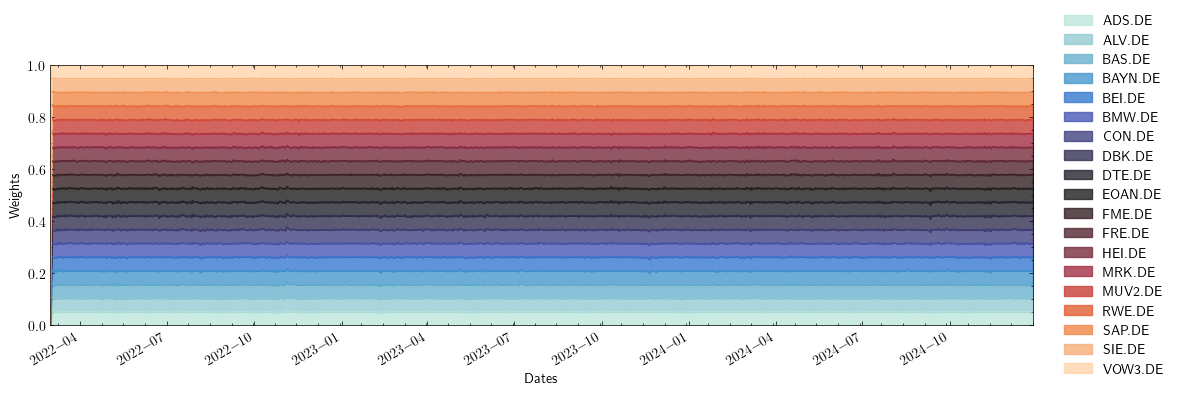

In [184]:
from utils.plotting_helpers import plot_buy_and_hold_weights
plot_buy_and_hold_weights(environment_train_buy_and_hold_sp500,test_data=test_data,ad_cash=False)

## MVO

Initial portfolio value:1000000
Final portfolio value: 1201231.5
Final accumulative portfolio value: 1.2012314796447754
Maximum DrawDown: -0.18824450160745165
Sharpe ratio: 0.5514144317694234


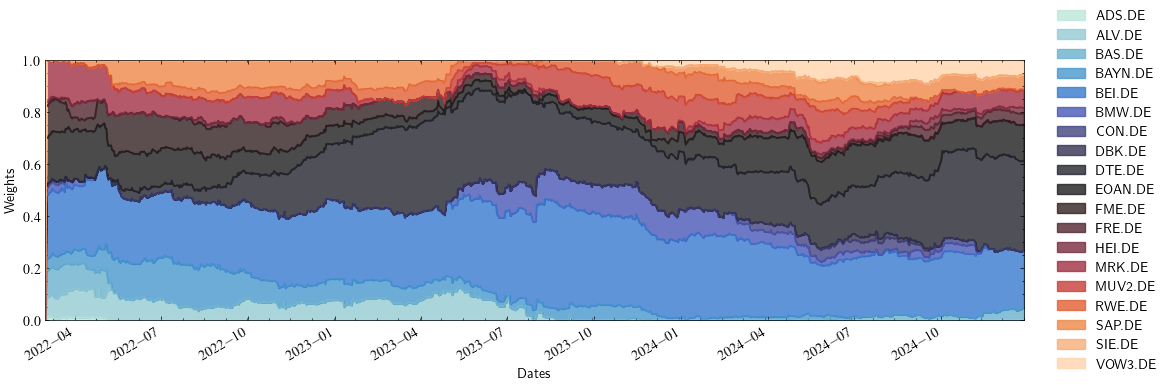

In [27]:
test_covariances = data_split(cleaned_data,TEST_START_DATE,TEST_END_DATE)
min_variacen_portfolio = mvo.mean_variance_optimization(test_covariances,commission_fee=0,window=42)
%matplotlib inline
plot_weights(min_variacen_portfolio[0].weights, min_variacen_portfolio[0].date, min_variacen_portfolio[1],add_cash=False,name='mvo_dow')

## MVO sharpe

Initial portfolio value:1000000
Final portfolio value: 1541533.5
Final accumulative portfolio value: 1.5415334701538086
Maximum DrawDown: -0.18922925000000002
Sharpe ratio: 0.9760738787183925


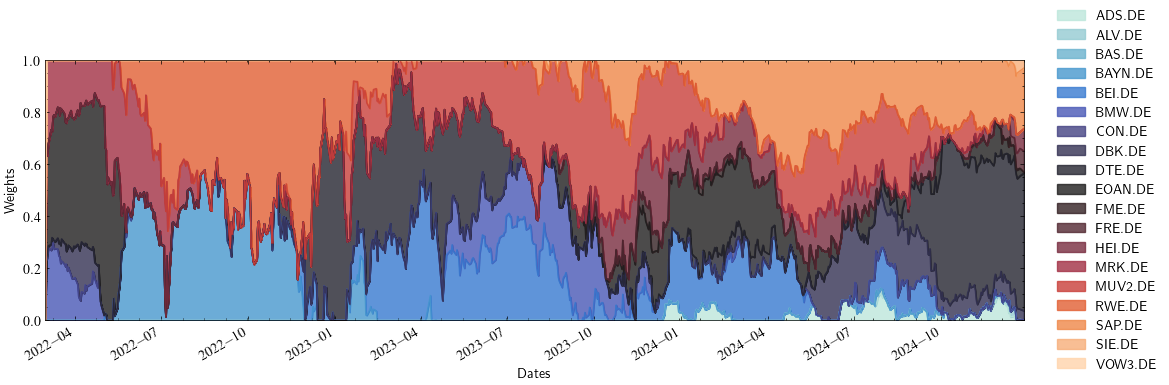

In [28]:
result_sharpe = mvo.mean_variance_optimization(test_covariances,commission_fee=0,objective='sharpe',window=42,risk_free_rate=0.04)
%matplotlib inline
plot_weights(result_sharpe[0].weights, result_sharpe[0].date, result_sharpe[1],add_cash=False,name='mvo_sharpe')

## PPO

In [44]:
%matplotlib inline

import torch
from torch import nn

from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
activ_func = nn.SiLU
use_sharpe_reward = False
optimizer = PortfolioOptimization(
    transaction_fee=0, comission_fee_model=None,
    tag="flat_state", sharp_reward=use_sharpe_reward, last_weight=False, remove_close=True,flatten_state=False,
    add_cash=False, env=PortfolioOptimizationEnv
)
# optimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return", "r_21", "r_42", "r_63",
#                                 "macd", "rsi_30"
#                                 ],
#                         model_name="td3",
#                         args={'gamma': 0.90, 'learning_rate': 1e-4,
#                             "buffer_size": 300_000, "batch_size": 124,
#                             "action_noise": "normal"},
#                         window_size=21,
#                         policy_kwargs=dict(
#                             activation_fn=activ_func,
#                         ),
#                         iterations=1000_000)

test_env = optimizer.create_environment(test_data,
                          features=["close", "log_return", "r_21", "r_42", "r_63","r_252",
                                    "macd", "rsi_30",
                                    ],
                                        window=21)
ppo_test_result = optimizer.load_from_file(
    'RecurrentPPO',test_env, 
    cwd="data/RecurrentPPO_close_log_return_r_21_r_42_r_63_r_252_macd_rsi_30_window_size_21_0.001_recurrent_ppo_dax_dataset_leaky_relu/RecurrentPPO_100000_steps"
    ,deterministic=True)

Successfully load model data/RecurrentPPO_close_log_return_r_21_r_42_r_63_r_252_macd_rsi_30_window_size_21_0.001_recurrent_ppo_dax_dataset_leaky_relu/RecurrentPPO_100000_steps
Initial portfolio value:250000
Final portfolio value: 308361.0
Final accumulative portfolio value: 1.2334439754486084
Maximum DrawDown: -0.2582368089987147
Sharpe ratio: 0.5122769311558628


# TD3

In [25]:
%matplotlib inline

import torch
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = PortfolioOptimization(
    transaction_fee=0, comission_fee_model=None,
    tag="flat_state", sharp_reward=False, last_weight=False, remove_close=True,flatten_state=True,
    add_cash=False, env=PortfolioOptimizationEnv
)
# optimizer.train_model(train_data,
#                       validation_data,
#                       features=["close", "log_return", "r_21", "r_42", "r_63",
#                                 "macd", "rsi_30","corr_list"
#                                 ],
#                       model_name="ppo",
#                       args={"n_steps":  1024, "batch_size": 64, 'learning_rate': 1e-4,
#                             'gamma': 0.85, 'gae_lambda': 0.85, 'ent_coef': 0.05},
#                       window_size=5,
#                       iterations=1000_000)

test_env = optimizer.create_environment(test_data,features=[
                                "close", "log_return", "r_21", "r_42", "r_63",
                                "macd", "rsi_30",'corr_list'
                                  ],window=42)
td3_test_result = load_from_file(
    'td3',test_env, 
    cwd="./td3_130000_steps"
    ,deterministic=True)

Successfully load model ./td3_130000_steps
Initial portfolio value:250000
Final portfolio value: 343837.875
Final accumulative portfolio value: 1.3753515481948853
Maximum DrawDown: -0.2273299751090193
Sharpe ratio: 0.7528503048136634


Successfully load model data\RecurrentPPO_close_log_return_r_21_r_42_r_63_macd_rsi_30_corr_list_window_size_42_0.001_rppo_dow_leaky_relu\RecurrentPPO_70000_steps
Initial portfolio value:250000
Final portfolio value: 366557.25
Final accumulative portfolio value: 1.46622896194458
Maximum DrawDown: -0.16898529264398932
Sharpe ratio: 0.9318852135075986


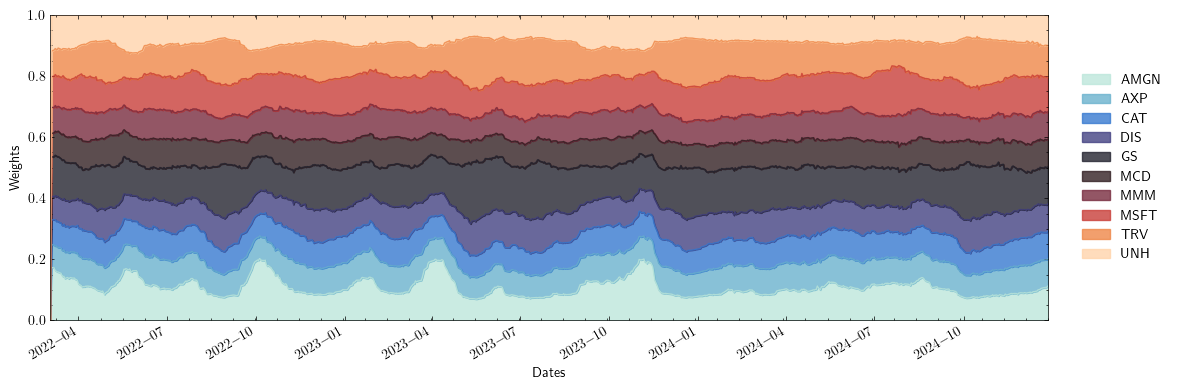

In [109]:
test_env = optimizer.create_environment(test_data,
                          features=["close", "log_return", "r_21", "r_42", "r_63",
                                    "macd", "rsi_30",'corr_list'
                                    ]
                                        ,window=42)
ppo_test_result = load_from_file(
    'ppo',test_env, 
    cwd="data\RecurrentPPO_close_log_return_r_21_r_42_r_63_macd_rsi_30_corr_list_window_size_42_0.001_rppo_dow_leaky_relu\RecurrentPPO_70000_steps"
    ,deterministic=True)
from utils.plotting_helpers import plot_weights
plot_weights(ppo_test_result[0].weights, ppo_test_result[0].date, ppo_test_result[1],add_cash=False,name='td3')

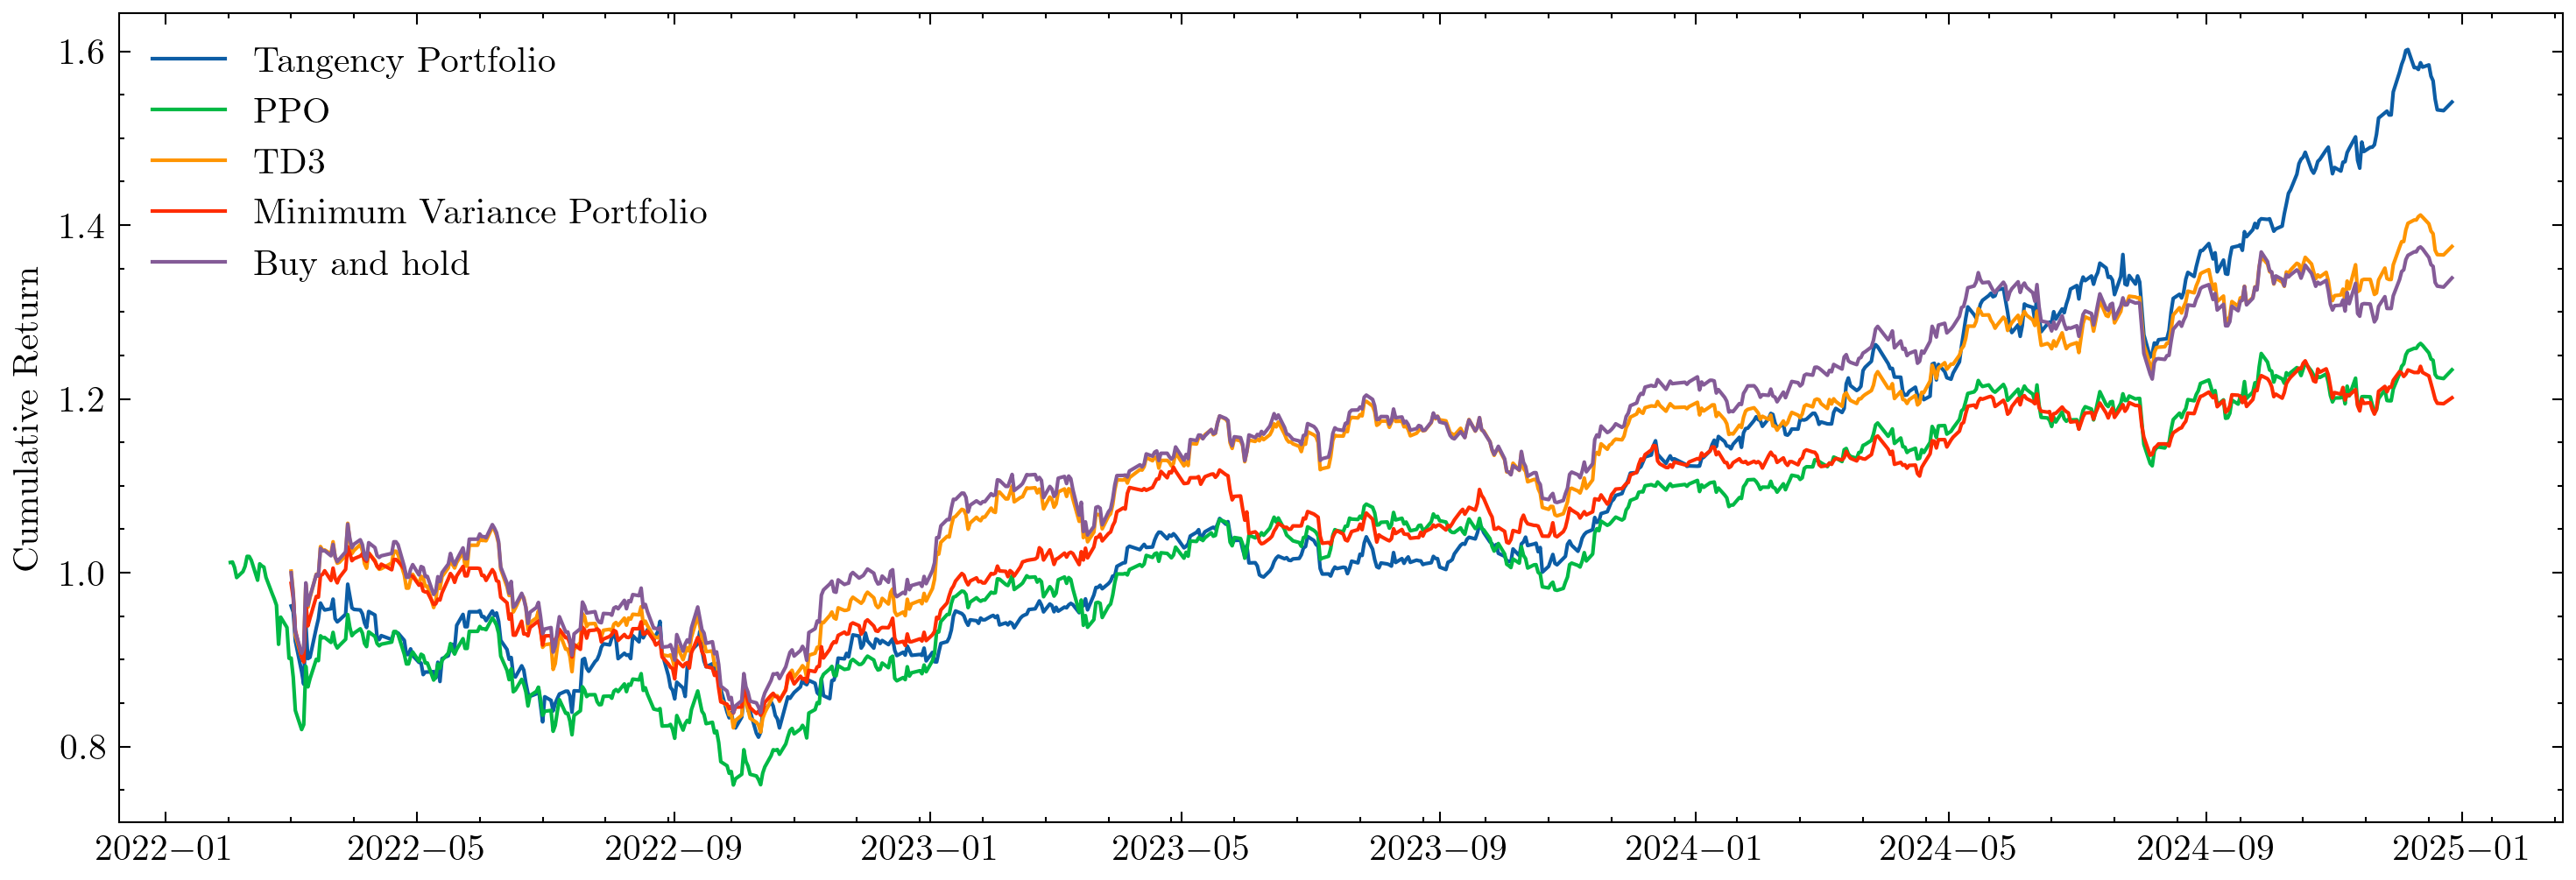

In [46]:
import matplotlib.pyplot as plt
import scienceplots
plt.rcdefaults()
%matplotlib inline
with plt.style.context('science', 'ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    plt.plot(result_sharpe[0].get('date'),(result_sharpe[0]['account'].pct_change() + 1).cumprod(),label='Tangency Portfolio')
    plt.plot(ppo_test_result[0].get('date'),(ppo_test_result[0]['account'].pct_change() +1).cumprod(),label='PPO')
    plt.plot(td3_test_result[0].get('date'),(td3_test_result[0]['account'].pct_change() +1).cumprod(),label='TD3')
    plt.plot(min_variacen_portfolio[0].get('date'),(min_variacen_portfolio[0]['account'].pct_change() + 1).cumprod(),label='Minimum Variance Portfolio')
    plt.plot(environment_train_buy_and_hold_sp500._date_memory,(pd.Series(environment_train_buy_and_hold_sp500._asset_memory["final"]).pct_change() + 1).cumprod(),label='Buy and hold')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.savefig('dax_comparison.png', dpi=500)
    plt.show()